In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## We will now consider the case when K=2
- The queueing system is G/M/s, with arrival rate being lambda1 during [0,t0] and lambda2 during [t0,T]

In [2]:
# arrival rate
lambda1 = 6
lambda2 = 9.9
arrival_rate = np.array([lambda1,lambda2])

# service rate
mu = 10

# total time, that is the office our is from 8:00 am to 6:00 pm, and will not accept new customers half hour before the end
T = 10

# time for the change in influx
t0 = 4

# let's consider the case when a new gate is open at time s, i.e. there are two counter serving
# the cost of operating one counter is c1 and two counters is c2, the upper bound for the daily cost is C
c1 = 5
c2 = 10
C = 8
s = 6

### To illustrate the idea and serves as a comparison, we start with only one counter throughout [0,T], i.e. s>T 

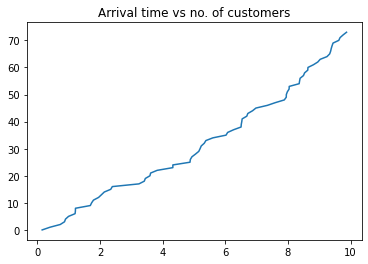

In [3]:
# For a single iteration of simulation
arrival_time=np.zeros([500,1])
# assign value of arrival time
n=0
while arrival_time[n]<10:
    if n==0:
        arrival_time[0]=np.random.exponential(1/lambda1)
        
    if arrival_time[n]<t0:
        arrival_time[n+1]+=arrival_time[n]+np.random.exponential(1/lambda1)
    else:
        arrival_time[n+1]+=arrival_time[n]+np.random.exponential(1/lambda2)
    n+=1

arrival_time=arrival_time[arrival_time>0][0:n,None]
plt.figure()
plt.plot(arrival_time,range(n))
plt.title("Arrival time vs no. of customers")
plt.show()
    

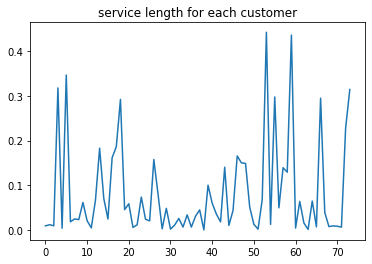

In [4]:
# service length
service_length=np.random.exponential(1/mu,[n,1])

plt.figure()
plt.plot(range(n),service_length)
plt.title("service length for each customer")
plt.show()

In [5]:
# service starting time & service ending time
# let's start with only one gate
service_star_time=np.zeros([n,1])
service_end_time=np.zeros([n,1])
for k in range(n):
    if k==0:
        service_star_time[k]=arrival_time[k]
    else:
        service_star_time[k]=max(arrival_time[k],service_end_time[k-1])
    service_end_time[k]=service_star_time[k]+service_length[k]
      

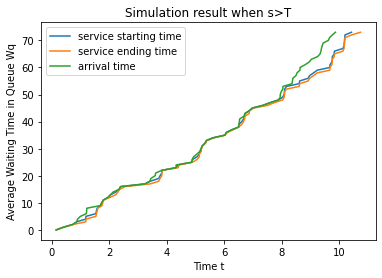

In [6]:
plt.figure()
plt.plot(service_star_time,range(n))
plt.plot(service_end_time,range(n))
plt.plot(arrival_time,range(n))
plt.xlabel("Time t")
plt.ylabel("Average Waiting Time in Queue Wq")
plt.title("Simulation result when s>T")
plt.legend(["service starting time","service ending time","arrival time"])
plt.show()

### Now, we consider introducing a counter at time s

In [7]:
# new service start and ending time with new gate introduced
service_star_s_time=np.zeros([n,1])
service_end_s_time=np.zeros([n,1])
for k in range(n):
    if k==0:
        service_star_s_time[k]=arrival_time[k]
    else:
        service_star_s_time[k]=max(arrival_time[k],service_end_s_time[k-1])
    service_end_s_time[k]=service_star_s_time[k]+service_length[k]
    if  service_end_s_time[k]>=s:
        print("Found k")
        break
        
service_star_s_time[k+1]=max(s,arrival_time[k+1])
service_end_s_time[k+1]=service_star_s_time[k+1]+service_length[k+1]
for j in range(k+2,n):
    service_star_s_time[j]=max(arrival_time[j],min(service_end_s_time[j-1],service_end_s_time[j-2]))
    service_end_s_time[j]=service_star_s_time[j]+service_length[j]
          

Found k


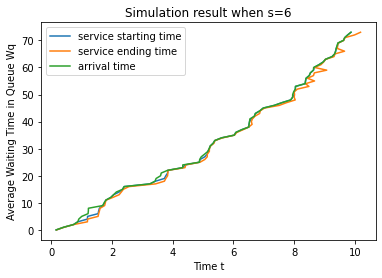

In [8]:
plt.figure()
plt.plot(service_star_s_time,range(n))
plt.plot(service_end_s_time,range(n))
plt.plot(arrival_time,range(n))
plt.xlabel("Time t")
plt.ylabel("Average Waiting Time in Queue Wq")
plt.title("Simulation result when s=6")
plt.legend(["service starting time","service ending time","arrival time"])
plt.show()

In [9]:
# waiting time given the gate is opened at time s
waiting_s_time=service_star_s_time-arrival_time
total_service_s_time=waiting_s_time+service_length
Wq_s=np.sum(waiting_s_time)/len(waiting_s_time)
print(Wq_s)

waiting_time=service_star_time-arrival_time
Wq=np.sum(waiting_time)/len(waiting_time)
print(Wq)

0.03712466729881936
0.20638424254237875


In the cell above, we compared the expected waiting time at single iteration before and after introducing the counter at time s. However, using only one iteration in simulation may cause instability in the result, so in the following sections, we consider multiple iterations. 

### Average over multiple iterations given s to get more accurate waiting time
- To facilitate implementation, we encapsulate some the codes above into functions

In [10]:
def GenerateTime(arrival_rate=np.array([2,4]),mu=3,T=10,t0=5):
    '''
    generate the arrival time and the service length of each customer
    '''
    arrival_time=np.zeros([500,1])
    # assign value of arrival time
    n=0
    while arrival_time[n]<T:
        if n==0:
            arrival_time[0]=np.random.exponential(1/arrival_rate[1])

        if arrival_time[n]<t0:
            arrival_time[n+1]+=arrival_time[n]+np.random.exponential(1/arrival_rate[0])
        else:
            arrival_time[n+1]+=arrival_time[n]+np.random.exponential(1/arrival_rate[1])
        n+=1

    arrival_time=arrival_time[arrival_time>0][0:n,None]
    # service length
    service_length=np.random.exponential(1/mu,[n,1])
    return (arrival_time,service_length)
    
    

In [11]:
def WaitingTimeS(arrival_time,service_length,s):
    '''
     compute the expected waitng time in queue when the new gate is introduced at s
    '''
    n=np.shape(arrival_time)[0]
    service_star_s_time=np.zeros([n,1])
    service_end_s_time=np.zeros([n,1])
    for k in range(n):
        if k==0:
            service_star_s_time[k]=arrival_time[k]
        else:
            service_star_s_time[k]=max(arrival_time[k],service_end_s_time[k-1])
        service_end_s_time[k]=service_star_s_time[k]+service_length[k]
        if  service_end_s_time[k]>=s:
            break
    if k+1<n:
        service_star_s_time[k+1]=max(s,arrival_time[k+1])
        service_end_s_time[k+1]=service_star_s_time[k+1]+service_length[k+1]
        for j in range(k+2,n):
            service_star_s_time[j]=max(arrival_time[j],min(service_end_s_time[j-1],service_end_s_time[j-2]))
            service_end_s_time[j]=service_star_s_time[j]+service_length[j]
    waiting_s_time=service_star_s_time-arrival_time   
    Wq_s=np.sum(waiting_s_time)/len(waiting_s_time)
    
    return Wq_s

In [12]:
def WaitingTime(arrival_time,service_length):
    '''
    compute the expected waiting time in queue when there is only one gate
    '''
    n=np.shape(arrival_time)[0]
    service_star_time=np.zeros([n,1])
    service_end_time=np.zeros([n,1])
    for k in range(n):
        if k==0:
            service_star_time[k]=arrival_time[k]
        else:
            service_star_time[k]=max(arrival_time[k],service_end_time[k-1])
        service_end_time[k]=service_star_time[k]+service_length[k]
        
    waiting_time=service_star_time-arrival_time   
    Wq=np.sum(waiting_time)/len(waiting_time)
    
    return Wq
    

In [13]:
def WqAverage(arrival_rate=np.array([2,4]),mu=3,T=10,t0=5,s=6,options=False):
    '''
    calculate the average weighting time over M iterations
    '''
    M=1000 # number of iterations
    Wq_s_averaged=0
    for i in range(M):
        (arrival_time,service_length)=GenerateTime(arrival_rate=np.array([2,4]),mu=3,T=10,t0=5)
        Wq_s_averaged+=WaitingTimeS(arrival_time,service_length,s)
        if options:
            if i%1000==0:
                print("Iteration",i)
    return Wq_s_averaged/M

In [14]:
# calculate the average weighting time over M iterations
M=10000 # number of iterations
Wq_s_averaged=0
Wq_averaged=0
for i in range(M):
    (arrival_time,service_length)=GenerateTime(arrival_rate=np.array([lambda1,lambda2]),mu=mu,T=10,t0=t0)
    Wq_s_averaged+=WaitingTimeS(arrival_time,service_length,s)
    Wq_averaged+=WaitingTime(arrival_time,service_length)
    if i%1000==0:
        print("Iteration",i)
Wq_s_averaged=Wq_s_averaged/M
Wq_averaged=Wq_averaged/M
print("Wq_s:",Wq_s_averaged,"Wq",Wq_averaged)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Wq_s: 0.10798437897034378 Wq 0.4106160270219368


From the cell above, we see a constantly outperformance after introducing the counter

### Optimize Wq over s in the feasible region

In [15]:
# the feasible region when k=2 is characterized as s>max(T*(c2-C)/(c2-c1),t0) for c2>c>c1
N=20
s_lst=np.linspace(max(T*(c2-C)/(c2-c1),t0),T,N)
Wq_s=np.zeros([N,1])

index=0
for s in s_lst:
    Wq_s[index]=WqAverage(arrival_rate=np.array([lambda1,lambda2]),mu=mu,T=10,t0=t0,s=s,options=False)
    index+=1

In [16]:
val, idx = min((val, idx) for (idx, val) in enumerate(Wq_s))

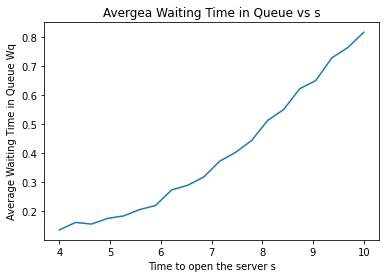

In [17]:
plt.figure()
plt.plot(s_lst,Wq_s)
plt.xlabel("Time to open the server s")
plt.ylabel("Average Waiting Time in Queue Wq")
plt.title("Avergea Waiting Time in Queue vs s")
plt.show()